In [3]:
import numpy as np
import biotuner
from biotuner.biotuner_utils import *
from biotuner.biotuner_object import *
import mne
from biotuner.harmonic_connectivity import *

In [25]:
import numpy as np
from biotuner.biotuner_object import compute_biotuner
from biotuner.metrics import ratios2harmsim, compute_subharmonics_2lists, euler
from biotuner.biotuner_utils import rebound_list
from biotuner.peaks_extension import harmonic_fit
import itertools
import seaborn as sbn
import matplotlib.pyplot as plt
import numpy as np
from mne.viz import circular_layout
from mne_connectivity.viz import plot_connectivity_circle


class harmonic_connectivity(object):
    """
    Class used to compute harmonicity metrics
    between pairs of sensors.
    """

    def __init__(
        self,
        sf=None,
        data=None,
        peaks_function="EMD",
        precision=0.1,
        n_harm=10,
        harm_function="mult",
        min_freq=2,
        max_freq=80,
        n_peaks=5,
    ):
        """
        Parameters
        ----------
        sf: int
            sampling frequency (in Hz)
        data : 2Darray(elec, numDataPoints)
            Electrodes x Time series to analyse.
        peaks_function: str
            Defaults to 'EMD'.
            See compute_biotuner class for details.
        precision: float
            Defaults to 0.1
            precision of the peaks (in Hz)
            When HH1D_max is used, bins are in log scale.
        n_harm: int
            Defaults to 10.
            Set the number of harmonics to compute in harmonic_fit function
        harm_function: str
            {'mult' or 'div'}
            Defaults to 'mult'
            Computes harmonics from iterative multiplication (x, 2x, 3x, ...nx)
            or division (x, x/2, x/3, ...x/n).
        min_freq: float, optional
            Defaults = 2. Minimum frequency (in Hz) to consider for peak extraction.
        max_freq: float, optional
            Defaults = 80. Maximum frequency (in Hz) to consider for peak extraction.
        n_peaks: int, optional
            Default = 5. Number of peaks to extract per frequency band.

        """
        """Initializing data"""
        if type(data) is not None:
            self.data = data
        self.sf = sf
        """Initializing arguments for peak extraction"""
        self.peaks_function = peaks_function
        self.precision = precision
        self.n_harm = n_harm
        self.harm_function = harm_function
        self.min_freq = min_freq
        self.max_freq = max_freq
        self.n_peaks = n_peaks

    def compute_harm_connectivity(self, metric='harmsim', delta_lim=20,
                                  save=False, savename='_', graph=True):
        # Initialize biotuner object
        self.metric = metric
        data = self.data
        list_idx = list(range(len(data)))
        pairs = list(itertools.product(list_idx, list_idx))
        harm_conn_matrix = []
        for i, pair in enumerate(pairs):
            data1 = data[pair[0]]
            data2 = data[pair[1]]
            #if i % (len(pairs) // 10) == 0:
            percentage_complete = int(i / len(pairs) * 100)
            print(f"{percentage_complete}% complete")
            bt1 = compute_biotuner(self.sf, peaks_function=self.peaks_function,
                                   precision=self.precision, n_harm=self.n_harm)
            bt1.peaks_extraction(data1, min_freq=self.min_freq,
                                 max_freq=self.max_freq, max_harm_freq=150,
                                 n_peaks=self.n_peaks, noverlap=None,
                                 nperseg=None, nfft=None, smooth_fft=1)
            list1 = bt1.peaks
            bt2 = compute_biotuner(self.sf, peaks_function=self.peaks_function,
                                   precision=self.precision, n_harm=self.n_harm)
            bt2.peaks_extraction(data2, min_freq=self.min_freq,
                                 max_freq=self.max_freq, max_harm_freq=150,
                                 n_peaks=self.n_peaks, noverlap=None,
                                 nperseg=None, nfft=None, smooth_fft=1)
            list2 = bt2.peaks
            if metric == 'subharm_tension':
                common_subs, delta_t, sub_tension_final, harm_temp, pairs_melody = compute_subharmonics_2lists(list1,
                                                                                                 list2,
                                                                                                 self.n_trans_harm,
                                                                                                 delta_lim=delta_lim,
                                                                                                 c=2.1)
                harm_conn_matrix.append(sub_tension_final)
            # compute the harmonic similarity between each pair of peaks from the two electrodes.
            if metric == 'harmsim':
                harm_pairs = list(itertools.product(list1, list2))
                ratios = []
                for p in harm_pairs:
                    if p[0] > p[1]:
                        ratios.append(p[0]/p[1])
                    if p[1] > p[0]:
                        ratios.append(p[1]/p[0])
                ratios = rebound_list(ratios)
                harm_conn_matrix.append(np.mean(ratios2harmsim(ratios)))

            if metric == 'euler':
                list_all = list1 + list2
                list_all = [int(x*10) for x in list_all]
                harm_conn_matrix.append(euler(*list_all))

            if metric == 'harm_fit':
                harm_pairs = list(itertools.product(list1, list2))
                harm_fit = []
                for p in harm_pairs:
                    a, b, c, d = harmonic_fit([4, 7.6],
                                              n_harm=10,
                                              bounds=0.5,
                                              function="mult",
                                              div_mode="div",
                                              n_common_harms=2)
                    harm_fit.append(len(a))
                harm_conn_matrix.append(np.sum(harm_fit))
        matrix = np.empty(shape=(len(data), len(data)))
        for e, p in enumerate(pairs):
            matrix[p[0]][p[1]] = harm_conn_matrix[e]
        #conn_matrix = matrix.astype('float')
        if graph is True:
            sbn.heatmap(matrix)
            plt.show()
        self.conn_matrix = matrix
        return matrix

    
    def plot_conn_matrix(self, conn_matrix=None, node_names=None):
        if conn_matrix is None:
            conn_matrix = self.conn_matrix
        if node_names is None:
            node_names = range(0, len(conn_matrix), 1)
            node_names = [str(x) for x in node_names]
        fig = plot_connectivity_circle(conn_matrix, node_names=node_names, n_lines=50,
                        fontsize_names=13, show=False, vmin=np.min(conn_matrix))


## Load dataset

In [7]:
filepath = 'data_examples_heavy/RS_pareidolia_MEG/s03_RS.fif'
epochs = mne.read_epochs(filepath)
data = epochs.get_data()

Reading c:\Users\Antoine\github\biotuner\examples\data_examples_heavy\RS_pareidolia_MEG\s03_RS.fif ...
    Found the data of interest:
        t =   -1000.00 ...    3000.00 ms
        0 CTF compensation matrices available


C:\Users\Antoine\AppData\Local\Temp\ipykernel_8156\1325415738.py:2: RuntimeWarning: This filename (data_examples_heavy/RS_pareidolia_MEG/s03_RS.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(filepath)


Not setting metadata
58 matching events found
No baseline correction applied
0 projection items activated


## Compute harmonic connectivity

The comodulogram is a matrix representing the strength of the coupling between the phase of driver frequencies and the amplitude of signal frequencies. The 'pac' method allows to extract pairs of driver/signal frequencies that exhibit higher scores of coupling

In [18]:
epochs.info

<Info | 16 non-empty values
 bads: []
 ch_names: MLC11-3105, MLC12-3105, MLC13-3105, MLC14-3105, MLC15-3105, ...
 chs: 270 Magnetometers
 ctf_head_t: CTF/4D/KIT head -> head transform
 custom_ref_applied: False
 dev_ctf_t: MEG device -> CTF/4D/KIT head transform
 dev_head_t: MEG device -> head transform
 dig: 3 items (3 Cardinal)
 experimenter: PL
 file_id: 4 items (dict)
 highpass: 0.5 Hz
 hpi_results: 1 item (list)
 lowpass: 200.0 Hz
 meas_date: 2021-05-26 10:36:00 UTC
 meas_id: 4 items (dict)
 nchan: 270
 projs: []
 sfreq: 1200.0 Hz
 subject_info: 1 item (dict)
>

0% complete
Number of peaks : 5
Number of peaks : 5
0% complete


c:\Users\Antoine\anaconda3\envs\biotuner\lib\site-packages\scipy\signal\_spectral_py.py:1961: UserWarning: nperseg = 12000 is greater than input length  = 4801, using nperseg = 4801
  warnings.warn('nperseg = {0:d} is greater than input length '


Number of peaks : 5
Number of peaks : 5
0% complete
Number of peaks : 5
Number of peaks : 5
0% complete
Number of peaks : 5
Number of peaks : 5
0% complete
Number of peaks : 5
Number of peaks : 5
0% complete
Number of peaks : 5
Number of peaks : 5
0% complete
Number of peaks : 5
Number of peaks : 5
0% complete
Number of peaks : 5
Number of peaks : 5
0% complete
Number of peaks : 5
Number of peaks : 5
0% complete
Number of peaks : 5
Number of peaks : 5
0% complete
Number of peaks : 5
Number of peaks : 5
0% complete
Number of peaks : 5
Number of peaks : 5
0% complete
Number of peaks : 5
Number of peaks : 5
0% complete
Number of peaks : 5
Number of peaks : 5
0% complete
Number of peaks : 5
Number of peaks : 5
0% complete
Number of peaks : 5
Number of peaks : 5
0% complete
Number of peaks : 5
Number of peaks : 5
0% complete
Number of peaks : 5
Number of peaks : 5
0% complete
Number of peaks : 5
Number of peaks : 5
0% complete
Number of peaks : 5
Number of peaks : 5
0% complete
Number of pe

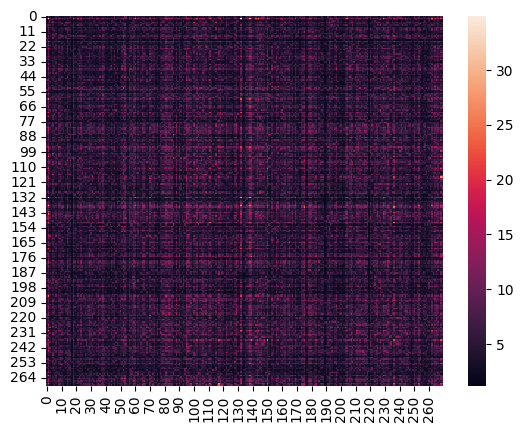

In [46]:
data_ = data[10]

HC = harmonic_connectivity(sf=1200,
        data=data_,
        peaks_function="EMD",
        precision=0.1,
        n_harm=10,
        harm_function="mult",
        min_freq=2,
        max_freq=80,
        n_peaks=5)

conn_matrix = HC.compute_harm_connectivity(metric='harmsim', delta_lim=20,
                                  save=True, savename='harmonic_connectivity_RS_s3_trial10', graph=True)

In [36]:
def plot_conn_matrix(conn_matrix=None, node_names=None, savefig=False, savename='test'):
    if node_names is None:
        node_names = range(0, len(conn_matrix), 1)
        node_names = [str(x) for x in node_names]
    fig = plot_connectivity_circle(conn_matrix, node_names=node_names, n_lines=20,
                    fontsize_names=13, show=False, vmin=15)
    if savefig is True:
        plt.savefig(savename+'.png', dpi=300)


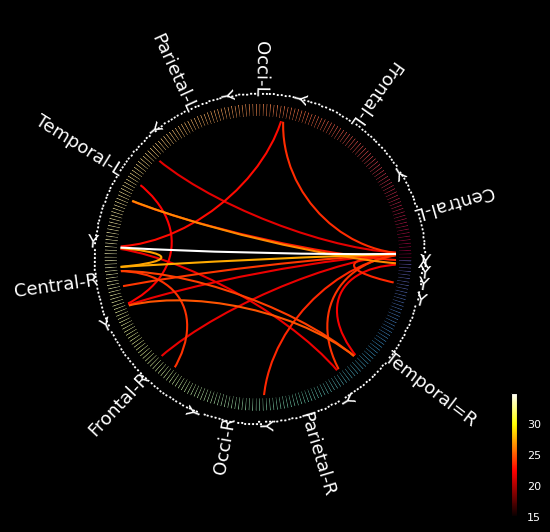

In [47]:
MEG_atlas = {'CL': list(range(0, 24)), 'FL': list(range(24, 57)), 'OL': list(range(57, 76)), 
             'PL': list(range(76, 97)), 'TL': list(range(97, 131)),
             'CR': list(range(131, 153)), 'FR': list(range(153, 186)), 'OR': list(range(186, 204)), 
             'PR': list(range(204, 226)), 'TR': list(range(226, 259)), 'CZ': list(range(259, 263)),
             'Fz': list(range(263, 266)), 'OZ': list(range(266, 269)), 'PZ': list(range(269, 270))
            }
MEG_regions = list(MEG_atlas.keys())
region_lists = []
for r in MEG_regions:
    region_lists.append([MEG_atlas[r]][0])
    
    
dict_names = {'Central-L':12, 'Frontal-L':41, 'Occi-L':67, 'Parietal-L':86, 'Temporal-L':111, 'Central-R':141,
              'Frontal-R':170, 'Occi-R':195, 'Parietal-R':215, 'Temporal=R':242}
edges = [0, 24, 57, 76, 97, 131, 153, 186, 204, 226, 259, 263, 266, 269, 270]
names = []
for i in range(270):
    if i in dict_names.values():
        names.append([name for name, idx in dict_names.items() if idx == i][0])
    if i in edges:
        names.append('Y')

    if i not in dict_names.values() and i not in edges:
        names.append('.')

plot_conn_matrix(conn_matrix, node_names=names, savefig=True, savename='harmonic_connectivity_RS_s3_trial10')

In [45]:
from fractions import Fraction
from typing import List, Tuple

def find_crossings(generators: List[Tuple[int, int]]) -> List[Tuple[int, int]]:
    """
    Finds the points in the Stern-Brocot tree where the convergents of at least two generator intervals cross.
    
    Args:
        generators: A list of tuples representing the generator intervals. Each tuple should contain two integers,
                    representing the numerator and denominator of the interval.
                    
    Returns:
        A list of tuples representing the fractions in the Stern-Brocot tree where the convergents of at least two
        generator intervals cross. Each tuple contains two integers, representing the numerator and denominator of
        the fraction.
    """
    sb_tree = [[Fraction(-10**10, 1), Fraction(1, 1), Fraction(10**10, 1)]]

    crossings = []
    
    for g in generators:
        a, b = g
        if b == 0:
            continue  # Skip generator intervals with a denominator of 0
        
        # Compute the convergents of the generator interval
        conv = []
        for i in range(10):
            c = a // b
            conv.append(Fraction(c))
            a, b = b, a - c * b
        
        # Check for crossings with previous generator intervals
        for i in range(len(sb_tree) - 1):
            frac1, frac2 = sb_tree[i], sb_tree[i+1]
            if frac2[0] < frac1[1]:
                continue
            for c in conv:
                if frac1[1] < c < frac2[0]:
                    crossings.append((c.numerator, c.denominator))
        
        # Add the generator interval to the Stern-Brocot tree
        new_row = []
        for i in range(len(sb_tree[-1]) - 1):
            new_row.append(sb_tree[-1][i])
            if sb_tree[-1][i+1] - sb_tree[-1][i] == Fraction(1, 1):
                new_row.append(sb_tree[-1][i] + sb_tree[-2][i+1])
        new_row.append(sb_tree[-1][-1])
        sb_tree.append(new_row)
    
    return crossings





generators = [Fraction(1, 1), Fraction(5, 4), Fraction(4, 3), Fraction(3, 2), Fraction(5, 3), Fraction(2, 1)]
crossings = find_crossings(generators)
print(crossings)


TypeError: cannot unpack non-iterable Fraction object